In [13]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize

In [15]:
#покажем что за данные используем - датасет Вина
file_path = '/home/vladislave/Документы/Data-science/lab2/winequality-white.csv'
data = pd.read_csv(file_path, sep=';')

print(data.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

# 0. покажем что датасет плохо сбалансирован 

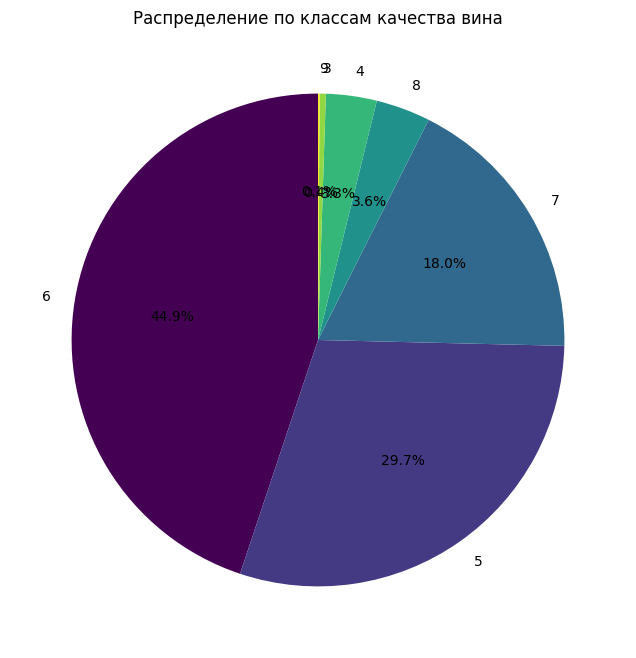

In [30]:
# Построим круговую диаграмму для визуализации долей каждого класса
class_distribution = data['quality'].value_counts(normalize=True)
plt.figure(figsize=(8, 8))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Распределение по классам качества вина')
plt.ylabel('')
plt.show()


# 1. Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.

In [17]:
#  тип разделим данные на признаки и целевую переменную
X = data.drop(['quality'], axis=1)
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:

model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

#предсказания на тестовой выборке
y_pred = model.predict(X_test)

# 2. Вычислить точность, полноту, специфичность.


Accuracy: 0.5306122448979592
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        49
           5       0.59      0.51      0.55       437
           6       0.52      0.75      0.61       660
           7       0.46      0.22      0.30       264
           8       0.00      0.00      0.00        53
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1470
   macro avg       0.22      0.21      0.21      1470
weighted avg       0.49      0.53      0.49      1470

Class 3: Specificity = 1.00
Class 4: Specificity = 1.00
Class 5: Specificity = 0.85
Class 6: Specificity = 0.43
Class 7: Specificity = 0.94
Class 8: Specificity = 1.00
Class 9: Specificity = 1.00


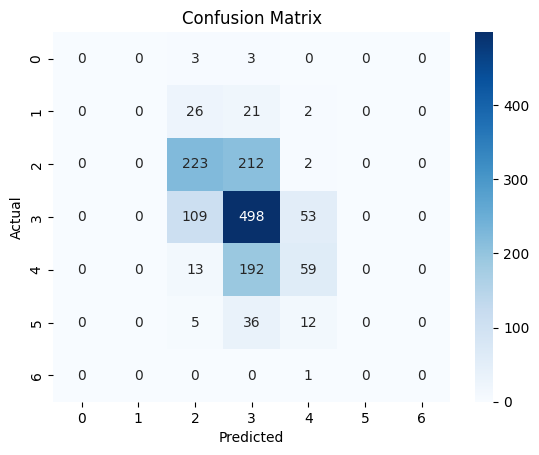

In [19]:
#метрики
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# отчет классификации через classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# покажем матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = {}

# поклассово рассчитаем  специфичность
for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class[f"Class {i + min(y.unique())}"] = specificity

# специфичность по каждому классу
for cls, spec in specificity_per_class.items():
    print(f"{cls}: Specificity = {spec:.2f}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 3. Построить кривую ошибок и найти площадь под ней. Построить для сравнения кривую "точность-полнота".

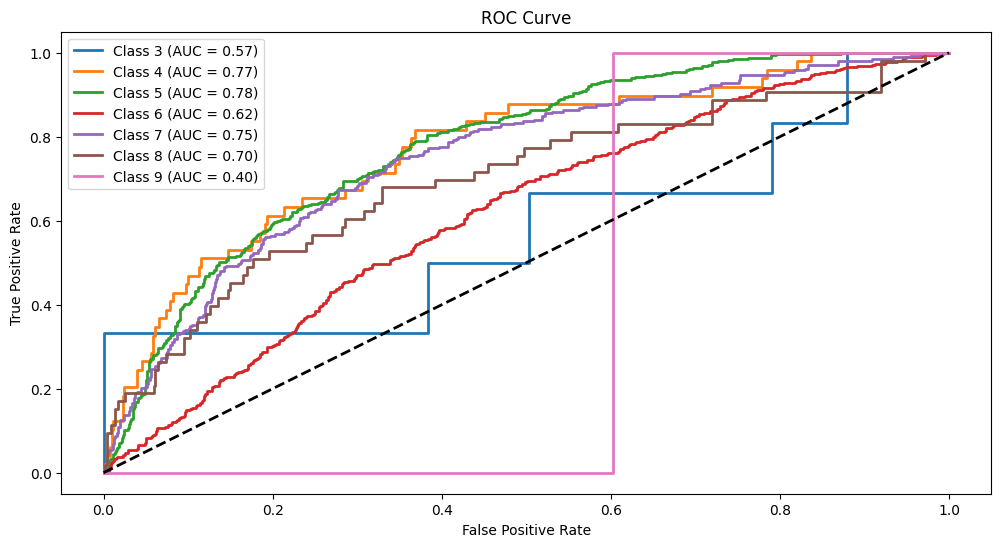

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Построение кривой ошибок (ROC-кривая)
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
y_test_proba = model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i + min(y.unique())} (AUC = {roc_auc:.2f})')

# Диагональная линия (случайная модель)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()



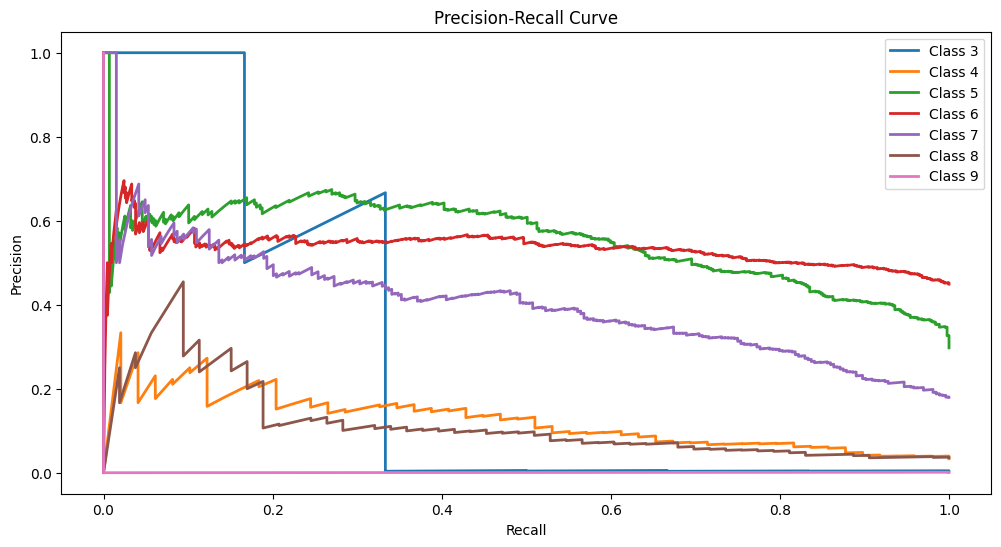

In [21]:
#кривая"точность-полнота" PR
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i + min(y.unique())}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


# 4. Разбить данные на обучающую и контрольную выборки. Построить ROC- кривую для каждой из подвыборок. Построить ROC- кривую на основе кроссвалидации.

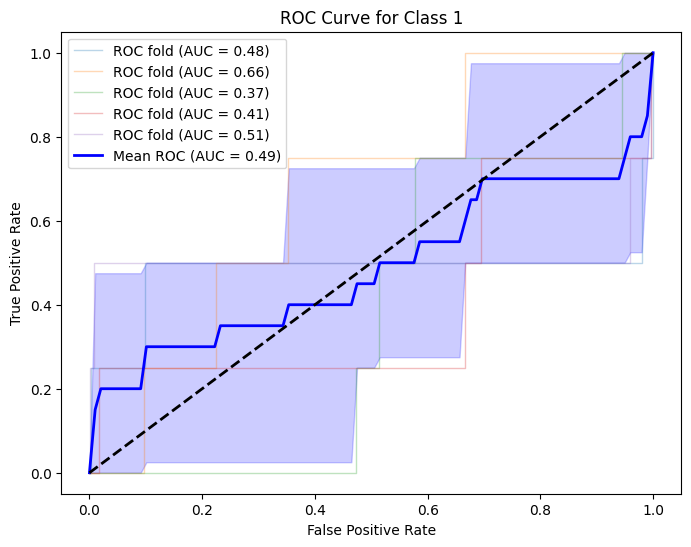

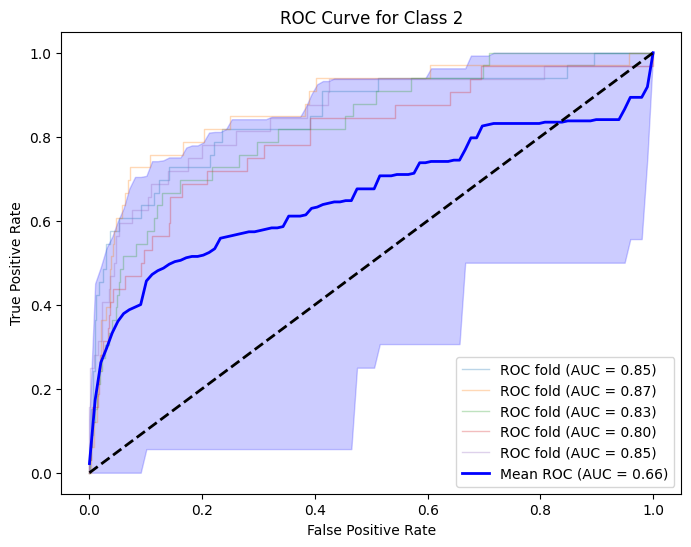

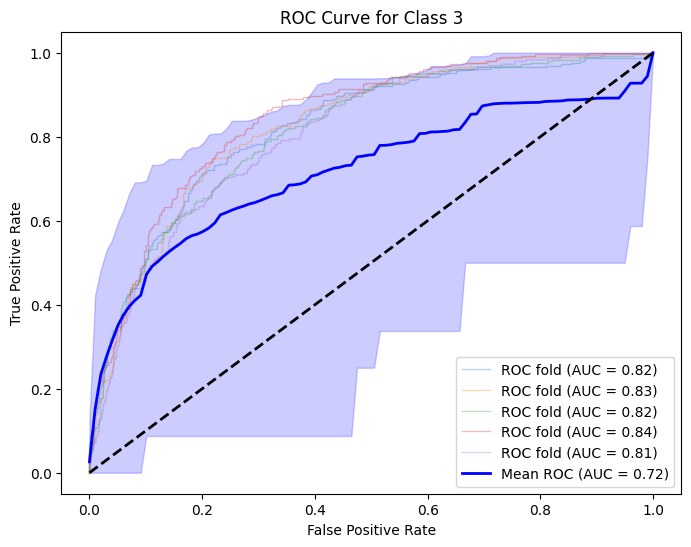

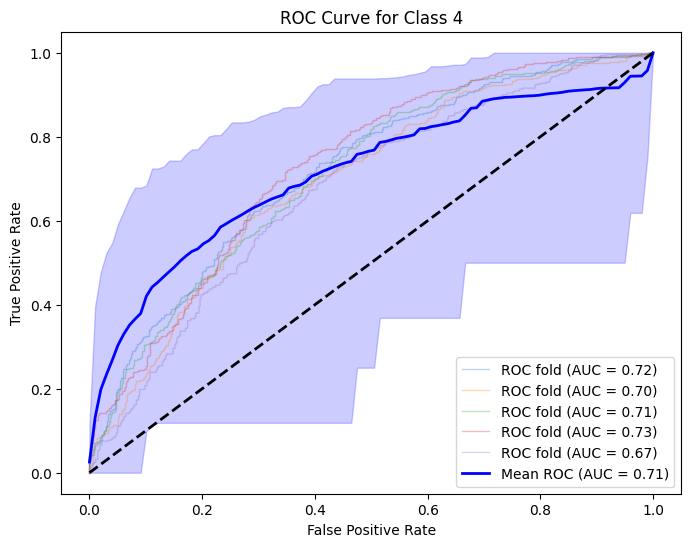

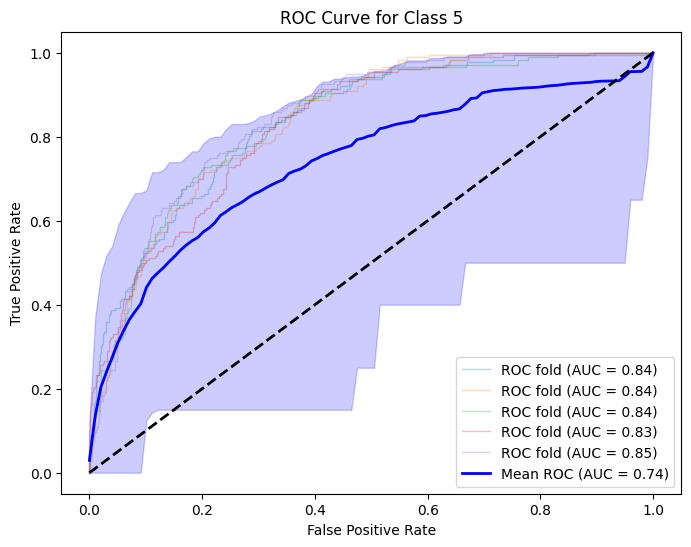

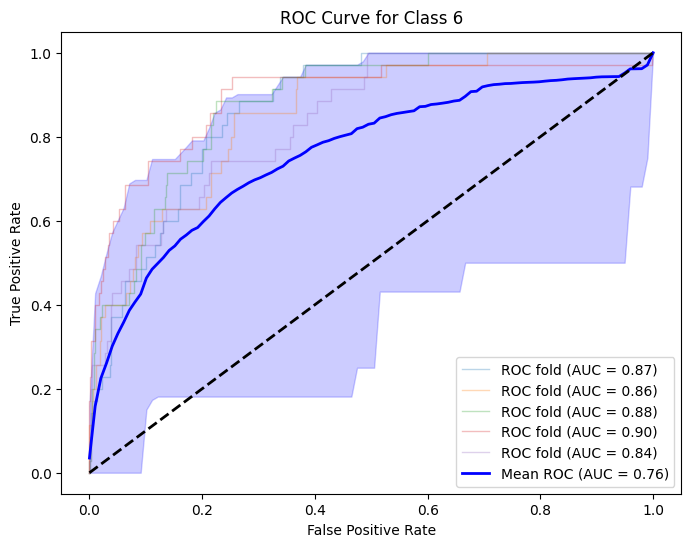

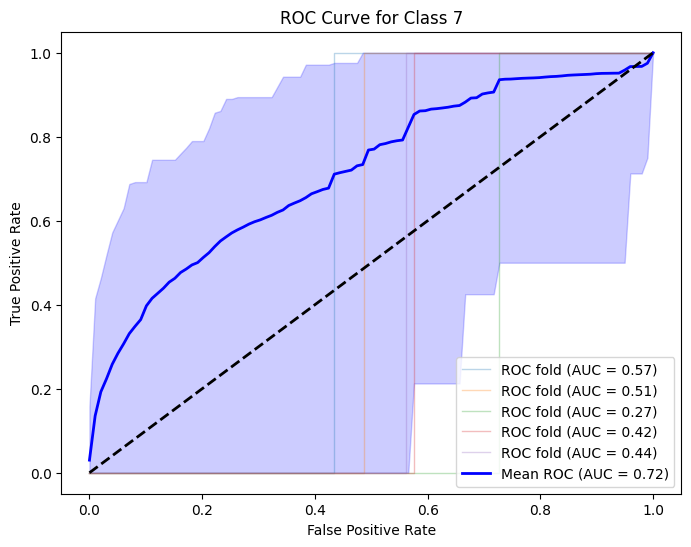

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# настроим кросс-валидацию
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
n_classes = len(np.unique(y))  # Количество классов
tprs = []
aucs = []

# кросс-валидация для ROC-кривой
for i in range(n_classes):
    plt.figure(figsize=(8, 6))
    
    for train_idx, val_idx in cv.split(X, y):
        X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

        # обучим модель на кросс-валидации
        model.fit(X_cv_train, y_cv_train)
        y_cv_proba = model.predict_proba(X_cv_val)
        y_cv_bin = label_binarize(y_cv_val, classes=sorted(np.unique(y)))

        # Рассчитаем ROC-кривую для текущего класса
        fpr, tpr, _ = roc_curve(y_cv_bin[:, i], y_cv_proba[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))

        # Построим ROC-кривую для текущего класса
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold (AUC = {:.2f})'.format(auc(fpr, tpr)))
    
    # Рассчитаем среднее и доверительный интервал для TPR
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Mean ROC (AUC = {:.2f})'.format(mean_auc))
    plt.fill_between(mean_fpr, np.percentile(tprs, 2.5, axis=0), np.percentile(tprs, 97.5, axis=0), color='blue', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i + 1}')
    plt.legend(loc='best')
    plt.show()


# 5. Исследовать влияние выбора критерия обучения на AUC. Один из критериев — log loss, ещё один или два — на выбор. Как вариант: сравнить AdaBoost с градиентным бустингом.

In [29]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, recall_score, accuracy_score

# Обучаем модели
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    roc_auc_scores = []
    log_loss_scores = []
    precision_scores = []
    recall_scores = []

    print(f"\nResults for {name}:\n")
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        log_loss_value = log_loss(y_test_bin[:, i], y_proba[:, i])
        
        # преобразуем вероятности в предсказания для вычисления precision и recall
        y_true_i = y_test_bin[:, i]
        y_pred_i = (y_proba[:, i] >= 0.5).astype(int)  # предсказания на основе вероятности

        precision = precision_score(y_true_i, y_pred_i)
        recall = recall_score(y_true_i, y_pred_i)

        roc_auc_scores.append(roc_auc)
        log_loss_scores.append(log_loss_value)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # вывод результатов для текущего класса
        print(f"Class {i}:")
        print(f"   AUC = {roc_auc:.2f}")
        print(f"   Log Loss = {log_loss_value:.2f}")
        print(f"   Precision = {precision:.2f}")
        print(f"   Recall = {recall:.2f}\n")

    # Средние значения по всем классам
    mean_auc = sum(roc_auc_scores) / len(roc_auc_scores)
    mean_log_loss = sum(log_loss_scores) / len(log_loss_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Overall Results for {name}:")
    print(f"   Mean AUC = {mean_auc:.2f}")
    print(f"   Mean Log Loss = {mean_log_loss:.2f}")
    print(f"   Mean Precision = {mean_precision:.2f}")
    print(f"   Mean Recall = {mean_recall:.2f}")
    print(f"   Accuracy = {accuracy:.2f}\n")
    print("-------------------------------------------")



Results for Logistic Regression:

Class 0:
   AUC = 0.57
   Log Loss = 0.03
   Precision = 0.00
   Recall = 0.00

Class 1:
   AUC = 0.77
   Log Loss = 0.13
   Precision = 0.00
   Recall = 0.00

Class 2:
   AUC = 0.78
   Log Loss = 0.50
   Precision = 0.63
   Recall = 0.33

Class 3:
   AUC = 0.62
   Log Loss = 0.66
   Precision = 0.56
   Recall = 0.46

Class 4:
   AUC = 0.75
   Log Loss = 0.41
   Precision = 0.59
   Recall = 0.08

Class 5:
   AUC = 0.70
   Log Loss = 0.15
   Precision = 0.00
   Recall = 0.00

Class 6:
   AUC = 0.40
   Log Loss = 0.01
   Precision = 0.00
   Recall = 0.00

Overall Results for Logistic Regression:
   Mean AUC = 0.66
   Mean Log Loss = 0.27
   Mean Precision = 0.25
   Mean Recall = 0.13
   Accuracy = 0.53

-------------------------------------------

Results for AdaBoost:

Class 0:
   AUC = 0.39
   Log Loss = 0.18
   Precision = 0.00
   Recall = 0.00

Class 1:
   AUC = 0.50
   Log Loss = 0.23
   Precision = 0.00
   Recall = 0.00

Class 2:
   AUC = 0.67
   